resources: get statevector (https://discuss.pennylane.ai/t/using-the-state-vector-directly/338/23) 



*   qng vs vanilla gd on bloch sphere




In [0]:
!pip install pennylane-sf --upgrade
!pip install qutip --upgrade
!pip install tensornetwork

Requirement already up-to-date: pennylane-sf in /usr/local/lib/python3.6/dist-packages (0.8.0)
Requirement already up-to-date: qutip in /usr/local/lib/python3.6/dist-packages (4.5.0)


In [0]:
import tensorflow as tf
import pennylane as qml
from pennylane.qnodes import PassthruQNode

import numpy as np
import scipy as sp

import qutip as qt
from qutip import Bloch, basis

In [0]:
dev = qml.device('default.qubit', wires=1)

def circuit(params, wires=0):
  qml.RX(params[0], wires=wires)
  qml.RY(params[1], wires=wires)

qnode = PassthruQNode(circuit, dev)

In [0]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)
qnodes = qml.map(circuit, obs, dev, measure='expval')
cost_fn  = qml.dot(coeffs, qnodes)

init_params = np.random.uniform(low=0, high=2*np.pi, size=2)

In [0]:
step_size = 0.01
max_iterations = 500
conv_tol = 1e-06
print_freq = 20

In [0]:
params = init_params
prev_energy = cost_fn(params)
qng_energies_block = []
all_states = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(cost_fn, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)

    energy = cost_fn(params)
    qng_energies_block.append(energy)
    
    conv = np.abs(energy - prev_energy)

    state_step = dev._state
    all_states.append(state_step)

    if n % print_freq == 0:
        print('Iteration = {:}'.format(n) ,'Energy = {:.8f} Ha,'.format(energy), 'Convergence parameter = {'
              ':.8f} Ha'.format(conv), "State", state_step)

    if conv <= conv_tol:
        qng_block_steps = n
        break

    prev_energy = energy

    state_final = dev._state

print()
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print("Final state", state_final)
print()
print('Number of iterations = ', n)

Iteration = 0 Energy = 0.15600095 Ha, Convergence parameter = 0.07461159 Ha State [0.46631216+0.49735071j 0.63331982-0.36619836j]
Iteration = 20 Energy = -1.09798577 Ha, Convergence parameter = 0.03398730 Ha State [-0.31035061+0.31209166j  0.8913321 +0.10866638j]
Iteration = 40 Energy = -1.37976149 Ha, Convergence parameter = 0.00419391 Ha State [-0.36584753+0.10158901j  0.92423926+0.04021262j]
Iteration = 60 Energy = -1.41081958 Ha, Convergence parameter = 0.00041861 Ha State [-0.37795909+0.0317502j   0.9251868 +0.01297065j]
Iteration = 80 Energy = -1.41388272 Ha, Convergence parameter = 0.00004086 Ha State [-0.38125941+0.00989945j  0.92440608+0.0040829j ]
Iteration = 100 Energy = -1.41418135 Ha, Convergence parameter = 0.00000398 Ha State [-0.38224392+0.00308785j  0.92405542+0.00127732j]

Final value of the ground-state energy = -1.41420560 Ha

Final state [-0.38245235+0.00162716j  0.92397354+0.00067352j]

Number of iterations =  112


In [0]:
### Convert all statevectors into QObjects ###

plot_states = []

# Select every 10th statevector #
lst = all_states[::10]

for i in range(len(lst)):
  psi = lst[i]
  psi = psi/np.linalg.norm(psi)

  # Convert to QObject in QuTiP #
  coords = [qt.Qobj(psi)]

  plot_states.append(coords)

print(plot_states)

[[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.46631216+0.49735071j]
 [0.63331982-0.36619836j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.20142199+0.50918516j]
 [ 0.827526  +0.123937j  ]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.31035061+0.31209166j]
 [ 0.8913321 +0.10866638j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.34895611+0.18020322j]
 [ 0.91709043+0.06856796j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.36584753+0.10158901j]
 [ 0.92423926+0.04021262j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.37389044+0.05684666j]
 [ 0.92544418+0.02296672j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.37795909+0.0317502j ]
 [ 0.9251868 +0.01297065j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[

In [133]:
from qutip.expect import expect
from qutip.operators import sigmax, sigmay, sigmaz

coords_x = []
coords_y = []
coords_z = []

for qobj in plot_states:
    st = qobj
    x = expect(sigmax(), st)
    y = expect(sigmay(), st)
    z = expect(sigmaz(), st)

    for i in range(len(x)):
      x_list = x[i]
      coords_x.append(x_list)

      y_list = y[i]
      coords_y.append(y_list)

      z_list = z[i]
      coords_z.append(z_list)

print(coords_x)
print(coords_y)
print(coords_z)

[0.22639143285988372, -0.20715010335590772, -0.48542317273075053, -0.6153362956892068, -0.6680909708674903, -0.6894182972162138, -0.6985418805442613, -0.7027374673369235, -0.704796195446504, -0.7058567751884971, -0.7064212361388007, -0.7067278025121644]
[-0.971489628882174, -0.8926551881498289, -0.6238039838524833, -0.3783797178880871, -0.2172084720381824, -0.12239088965322033, -0.06855449054086031, -0.03832740216178432, -0.021415510009928116, -0.011963768537181873, -0.006683174224109966, -0.003733273646716907]
[-0.0703904830358788, -0.4003193097376523, -0.6125625952551976, -0.6915128576522761, -0.7116705237117618, -0.7139487947979115, -0.7122777007265986, -0.7104161190769922, -0.7090865242092457, -0.7082535429935272, -0.7077601092986372, -0.7074757068791878]


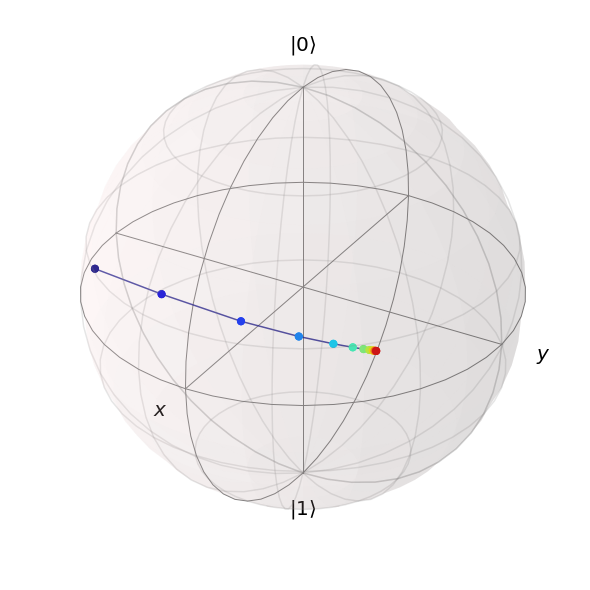

In [149]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

### Settings for Bloch sphere visualization ###

# normalize colors #
nrm = mpl.colors.Normalize(0, len(coords_x))
colors = cm.jet(nrm(range(len(coords_x))))
b = Bloch()
b.sphere_alpha = 0.1
b.figsize = [8,8]
b.point_color = list(colors)
b.point_marker = 'o'
b.point_size = [50]

# Add points
b.add_states(plot_states, 'point')

# Add line
b.add_points([coords_x, coords_y, coords_z], 'l')

b.show()